# Create AOI Image Tiles 

This notebook is used to create image tiles at DHS survaey locations for a given AOI (UTM Zone) using resampled and spatially aligned GeoTiff raster files that were previously created for the specific UTM zone using `prep_geospatial_data.ipynb`. The following processing steps are performed.

1. Define configurations (required input files, AOI parameters, file naming, etc.) 
2. Extract survey data from the Pakistan DHS shape file (specifically, Cluster IDs and GPS lat, lon)
3. Load AOI Raster Data
4. Convert each survey GPS location to the same UTM zone as the AOI image stack
5. Loop through all GPS locations (in UTM) and identify which points are within the AOI image stack
6. Crop image tiles from the AOI image stack:

    - For each GPS location (in UTM), find the nearest vertex in the image stack
    - Use that vertex point as the center of a bounding box for cropping an image tile from the stack for each data type (224 x 224)
    - Save each crop as a data sample with an associated file name that clearly identifies the data sample
    
## File System Structure

The top level file structure is shown below which includes five folders and three notebooks.

<pre style="font-family: monospace;">
<span style="color: blue;">./AOI       </span>  <span style="color: gray;"># AOI Image Stacks and Image Tiles</span>  
<span style="color: blue;">./DHS       </span>  <span style="color: gray;"># DHS survey data</span>
<span style="color: blue;">./gist_utils</span>  <span style="color: gray;"># Python package with convenience functions</span>
<span style="color: gray;">./Nightlights</span>
<span style="color: gray;">./Population</span>
<span style="color: gray;">./Rainfall</span>

<span style="color: blue;">./prep_aoi_image_tiles.ipynb (this notebook)</span>
<span style="color: gray;">./prep_geospatial_data.ipynb</span>
<span style="color: gray;">./prep_rainfall_chirps.ipynb</span>
</pre>


## Input

The input GeoTiff files for this notebook come from this file structure (previoulsy generated by `prep_geospatial_data.ipynb`):

<pre style="font-family: monospace;">
./Nightlights/
    output/PK/42N/
        VNL_v22_npp-j01_2022_global_vcmslcfg_median_PK_42N_4_resampled_average.tif

./Population/
    output/PK/42N/
        landscan-global-2022_PK_42N_4_resampled_average.tif
            
./Rainfall/
    output/PK/42N/
        chirps-v2.0.2023_PK_42N_avg_PK_42N_4_resampled_average.tif      
</pre>

The first code cell in this notebook copies these resampled files into a new file stricture to create an Image Stack for the specified country and UTM zone.


## Output

This notebook produces the following (parallel) file structure which contains image tiles for each of the DHS survey locations for each data type for the specificed country and UTM zone. Additionally, a Virtual Reference Table (VRT) file is produced for each datatype that references all the image tiles. These VRT files provide a convenient way to load the rastewr image tiles in QGIS for visual inspection.

<pre style="font-family: monospace;">
./AOI/
    PK/
        42N/
            Image_Tiles/
                Nightlights/
                    # Cropped image tiles at each DHS cluster location.
                    PK_42N_001_C-002_Nightlights_2022_400m.tif
                    PK_42N_002_C-003_Nightlights_2022_400m.tif
                        :
                    PK_42N_265_C-415_Nightlights_2022_400m.tif
                
                Population/
                    PK_42N_001_C-002_Population_2022_400m.tif
                    :
                
                Rainfall/
                    PK_42N_001_C-002_Rainfall_2023_400m
                    :
            
                PK_42N_Nightlights_2022_400m.vrt
                PK_42N_Population_2022_400m.vrt
                PK_42N_Rainfall_2023_400m.vrt
</pre>

## File Prep [One Time Copy]

Each of the re-sampled GeoTiff files genertead by `prep_geospatial_data.ipynb` for each data type for the specified counrty and UTM zone should be copied to the corresponding `Image_Stack` folder as shown below. This file structure below constitutes the "Image Stack" for the specified country and UTM zone. 

The following code cell automates this process. Once the Image Stack in the file structure below has been populated the remainder of this notebook can be executed to create Image Tiles for a specified country and UTM zone.

<pre style="font-family: monospace;">
./AOI/
    PK/
        42N/
            Image_Stack/
                # Resampled, spatially aligned image stack.
                chirps-v2.0.2022_42N_avg_42N_2022_bilinear_4_resampled.tif
                landscan-global-2022_42N_2022_average_4_resampled.tif
                VNL_v22_npp-j01_2022_global_vcmslcfg_median_42N_2022_median_average_4_resampled.tif
            
</pre>

In [1]:
import os
import shutil
import glob
from osgeo import gdal, osr, ogr 
from dataclasses import dataclass

# Import module that contains several convenience functions (e.g., gdal wrappers)
from gist_utils import *

# Adding path to gdal commands for local system
os.environ['PATH'] += ':/Users/billk/miniforge3/envs/py39-pt/bin/' 


# Set to True to copy re-sampled data to create the Image Stack for the specified country.
#-----------------------------------------------------------------------------------------
make_image_stack = False
#-----------------------------------------------------------------------------------------

In [2]:
if make_image_stack:
    
    # Set the country code
    country_code = 'PK'
    data_types = ['Rainfall', 'Nightlights', 'Population']
    source_base = './'
    destination_base = './AOI/'

    # Function to create directory if it doesn't exist
    def ensure_dir(directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    # Scan each data type in the source directory
    for data_type in data_types:
        source_path = os.path.join(source_base, data_type, 'output', country_code)

        # Walk through the directories in the source path
        for root, dirs, files in os.walk(source_path):
            for dir_name in dirs:

                # Build the path to search for TIFF files
                file_search_path = os.path.join(root, dir_name, '*resampled*.tif')
                # Use glob to find files that match the pattern
                for file_path in glob.glob(file_search_path):

                    # Build the destination path
                    destination_path = os.path.join(destination_base, country_code, dir_name, 'Image_Stack')
                    # Ensure the destination directory exists
                    ensure_dir(destination_path)
                    # Copy the file to the destination
                    shutil.copy(file_path, destination_path)
                    print(f"Copied {file_path} to {destination_path}")

    print("File copying completed.")

## Required Configurations

The following configurations are required for each execution of this notebook: the two-letter country code and the UTM Zone(s). The UTM zone, combined with the country's latitude band, defines the cropped region for each data type. This notebook must be executed once for each applicable UTM zone.

For example, if a country has three UTM zones, like Pakistan, the notebook should be executed once for each zone (3 times). Note that each data type is automatically handled for each zone when generating image tiles.

<pre style="font-family: monospace;">
<span style="color: blue;">country_code= 'PK'</span>  # Set the country code
<span style="color: blue;">utm_zone    = '42N'</span> # Set the UTM zone
</pre>


## UTM Zones by Country
The following table is provided as a convenient reference for countries of interest and their corresponding UTM zones.

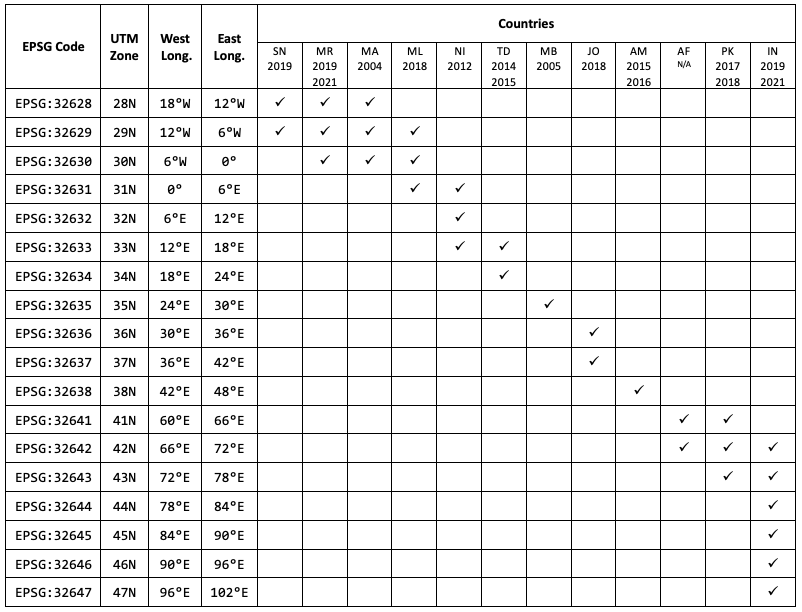


## 1 Configurations

The following settings must be specified:
```
shapefile_path: Path to the DHS country shape file that comntains the survey locations
aoi_name:       Country code and UTM zone (e.g., PK_42N)
```

In [3]:
# Function to check if a UTM zone is valid for a given country
def is_valid_zone(country_code, utm_zone):
    return utm_zone in aoi_configurations[country_code]['valid_zones']

In [4]:
#-------------------------------------------------
# REQUIRED CONFIGURATIONS HERE
#-------------------------------------------------
country_code = 'PK'   # Set the country code
utm_zone     = '43N'  # Set the UTM zone
#-------------------------------------------------

shapefile_path = aoi_configurations[country_code]['shapefile']

# Check if the selected UTM zone is valid for the chosen country
if is_valid_zone(country_code, utm_zone):
    lat_north = aoi_configurations[country_code]['lat_north']
    lat_south = aoi_configurations[country_code]['lat_south']
    print(f"Country:   {country_code}\nUTM Zone:  {utm_zone}\nLat North: {lat_north}\nLat South: {lat_south}\n")
else:
    print(f"UTM Zone {utm} is not valid for country {aoi}.")
    
utm_code = get_epsg_code(utm_zone)
case = country_code + '_' + utm_zone 

print(utm_code)
print(case)

Country:   PK
UTM Zone:  43N
Lat North: 37.0
Lat South: 24.0

EPSG:32643
PK_43N


In [5]:
# Shape file fields
cluster_field  = 'DHSCLUST'
lat_field      = 'LATNUM'
lon_field      = 'LONGNUM'

# The code further below will check that the input rasters (above) match the expected CRS and pixel size
expected_crs         = get_epsg_code(utm_zone)
expected_pixel_size  = (400, 400)    # This should match the pixel size in the input rasters

# Set the resolution for programmatic file naming below
res = expected_pixel_size[0]

# Build a list of the raster (produced by: prep_geospatial_data.ipynb)
aoi_image_stack_folder = f'./AOI/{country_code}/{utm_zone}/Image_Stack/'

# List all files in the image stack
aoi_image_stack_paths = [os.path.join(aoi_image_stack_folder, file) for file in os.listdir(aoi_image_stack_folder) if file.endswith('.tif')]

# Image tile outputs (folders where image tiles are stored for each data type)
image_tile_folders = []
image_tile_folders.append(f'./AOI/{country_code}/{utm_zone}/Image_Tiles/Nightlights/')
image_tile_folders.append(f'./AOI/{country_code}/{utm_zone}/Image_Tiles/Population/')
image_tile_folders.append(f'./AOI/{country_code}/{utm_zone}/Image_Tiles/Rainfall/')

image_tile_suffixes = []
image_tile_suffixes.append(f'Nightlights_2022_{res}m')
image_tile_suffixes.append(f'Population_2022_{res}m')
image_tile_suffixes.append(f'Rainfall_2023_{res}m')

# VRT filename suffix
vrt_file_suffixes = []
vrt_file_suffixes.append(f'Nightlights_2022_{res}m')
vrt_file_suffixes.append(f'Population_2022_{res}m')
vrt_file_suffixes.append(f'Rainfall_2023_{res}m')

## 2 Extract Cluster IDs and Associated GPS Coordinates

In [6]:
if os.path.exists(shapefile_path):
    print("File exists.")
else:
    print("File does not exist.")

File exists.


In [7]:
! ls -l

total 1096
drwxr-xr-x  16 billk  staff     512 Jul 13 15:03 AOI
drwxr-xr-x  68 billk  staff    2176 Jul 12 13:42 DHS
drwxr-xr-x  16 billk  staff     512 Jul  6 00:24 Nightlights
drwxr-xr-x  11 billk  staff     352 Jul  6 00:24 Population
drwxr-xr-x  12 billk  staff     384 Jul  6 00:24 Rainfall
-rw-r--r--   1 billk  staff    5141 Jul  7 11:27 copy_geospatial_data_to_aoi_image_stack.ipynb
drwxr-xr-x   7 billk  staff     224 Jul 13 14:47 gist_utils
-rw-r--r--   1 billk  staff  115492 Jul 13 14:44 html_byte_string.ipynb
-rw-r--r--   1 billk  staff  140387 Jul 13 15:04 prep_aoi_image_tiles.ipynb
-rw-r--r--   1 billk  staff  154788 Jul 13 15:02 prep_geospatial_data.ipynb
-rw-r--r--   1 billk  staff  131996 Jul 13 15:01 prep_rainfall_chirps.ipynb


In [8]:
cluster_data = extract_cluster_info(shapefile_path, cluster_field, lat_field, lon_field)

# Print a few records
for idx in range(0,5):
    print(cluster_data[idx])   

(1.0, 36.4499182254, 72.5715578674)
(2.0, 35.8919142536, 71.7268731073)
(3.0, 35.1695664132, 71.8344582034)
(4.0, 35.4247289555, 72.1639311741)
(5.0, 35.0056955272, 71.7764776856)


## 3 Load AOI Raster Data

In [9]:
# Initialize a list to store the results
results = []

# Loop through each raster path and call the function
for path in aoi_image_stack_paths:
    
    raster, crs_match, pixel_size_match = load_raster(path, expected_crs, expected_pixel_size)
    result = {
        'path': path,
        'raster': raster, 
        'crs_match': crs_match,
        'pixel_size_match': pixel_size_match
    }
    results.append(result)

### Check Image Stack Metadata 

In [10]:
# Check 
# !gdalinfo {aoi_image_stack_paths[0]}

In [11]:
# # Check 
# !gdalinfo {aoi_image_stack_paths[1]}

In [12]:
# # Check 
# !gdalinfo {aoi_image_stack_paths[2]}

## 4 Convert DHS GPS Locations to UTM

In [13]:
all_crs_match = all(result['crs_match'] for result in results)

if all_crs_match:
    utm_coordinates = convert_cluster_coordinates(cluster_data, src_crs='EPSG:4326', dst_crs=expected_crs)
    print(len(utm_coordinates))
    print(utm_coordinates[0])
else:
    print("*** Error: CRS does not match.")

561
(1, 282360.92079707806, 4036594.013646104)


## 5 Find DHS Points that Fall within the Input Raster Files
The input raster files were previously cropped, projected to the same UTM zone, and resampled to the same pixel size. The cropping was extended in longitide to accomodate cropping near the boundaries. So the raster files intentionally extend beyond the longitude boundaries of the UTM zone. 

When the function below is called to determine which DHS points fall within the boundaries of the raster file, the raster file itself is not used to determine inclusion, but rather the longitude bands for the given UTM zone. 

In [14]:
all_pixel_match = all(result['pixel_size_match'] for result in results)

if all_pixel_match:
    # Collect number of points in each dataset for comparison
    number_of_points_per_dataset = []

    for result in results:
        raster = result['raster']
        
        points_within_raster = find_points_within_raster_zone(raster, utm_coordinates)
        
        # Store the points within raster into the results dictionary for each raster
        result['points_within_raster'] = points_within_raster
        number_of_points_per_dataset.append(len(points_within_raster))
        print(f"Points w/in bounds: {result['path']}: {len(points_within_raster)}\n")

    # Check if all datasets have the same number of points
    if len(set(number_of_points_per_dataset)) == 1:
        print("All datasets have the same number of points.")
    else:
        print("Warning: Datasets have varying numbers of points. Here are the counts per dataset:", number_of_points_per_dataset)

else:
    print("Pixel size match does not match for one or more rasters.")


epsg_code:  EPSG:32643
Points w/in bounds: ./AOI/PK/43N/Image_Stack/chirps-v2.0.2023_PK_43N_avg_PK_43N_4_resampled_average.tif: 281

epsg_code:  EPSG:32643
Points w/in bounds: ./AOI/PK/43N/Image_Stack/landscan-global-2022_PK_43N_4_resampled_average.tif: 281

epsg_code:  EPSG:32643
Points w/in bounds: ./AOI/PK/43N/Image_Stack/VNL_v22_npp-j01_2022_global_vcmslcfg_median_PK_43N_4_resampled_average.tif: 281

All datasets have the same number of points.


## Debug:  `points_within_raster`

In [15]:
# for idx, item in enumerate(points_within_raster[:100]):
#     x, y = item['point'].coords[0]  # Assuming the point has coords attribute which is a tuple
#     lat, lon = utm_to_latlon(x, y)
#     if lon > 72.0 or lon < 66.0:
#         print(f"Point: POINT ({x:.3f} {y:.3f}) ({lat:.3f} {lon:.3f}) with Cluster ID: {item['cluster_id']}")
#         x,y = latlon_to_utm(lat,lon)
#         print(f"Point: POINT ({x:.3f} {y:.3f})")

In [16]:
# #----------------
# # TEST CASE
# #----------------
# specific_cluster_id = 101  # The cluster ID you are interested in

# # Initialize an empty list to store specific points
# specific_points = []

# # Loop through each point and check the cluster ID
# for item in points_within_raster:
#     if item['cluster_id'] == specific_cluster_id:
#         specific_points.append(item)
#         print(f"Point: {item['point']} with Cluster ID: {item['cluster_id']}")

In [17]:
# # Use a point that was determined above to be within the AOI.
# print(points_within_raster[0])

# first_point = points_within_raster[0]  # Get the first point from the list

# # Now access its x and y coordinates for use with find_nearest_vertex() below.
# x = first_point['point'].x
# y = first_point['point'].y

## Debug: `find_nearest_vertex`
Test find_nearest_vertex() which will be used further below from within crop_raster()

In [18]:
# first_point = specific_points[0]  # Get the first point from the list

# # Now access its x and y coordinates for use with find_nearest_vertex() below.
# x = first_point['point'].x
# y = first_point['point'].y

### Rasterio Version

In [19]:
# nearest_vertex = find_nearest_vertex_rasterio(results[0]['raster'], x, y)
# print("Nearest vertex UTM coordinates:", nearest_vertex)

### GDAL Version

In [20]:
# debug = True
# rasterio_dataset = results[0]['raster']
# if isinstance(rasterio_dataset, rasterio.io.DatasetReader):
#     raster_path = rasterio_dataset.name
# else:
#     raise ValueError("The input must be a rasterio dataset.")

# # Open the raster file using GDAL
# gdal_raster = gdal.Open(raster_path, gdal.GA_ReadOnly)

# nearest_vertex = find_nearest_vertex_gdal(gdal_raster, x, y)
# print("Nearest vertex UTM coordinates:", nearest_vertex)

## 6 Crop Image Tiles from AOI Image Stack
Loop over each data type which is stored in memory as a raster and crop an image tile of the specified size for each of the survey points specified in the `points_within_raster` list. Additionally, build a VRT file which referneces the image tiles for each data type. The VRT facilitates  loading a large number of image tiles in QGIS for visualization purposes.

In [21]:
# Loop over each result and its corresponding image tile path
idx = 0
for result, image_tile_folder, image_tile_suffix in zip(results, image_tile_folders, image_tile_suffixes):
    
    raster = result['raster']
    
    aoi_name = f"{country_code}_{utm_zone}"
    
    crop_raster_rasterio(raster, points_within_raster, aoi_name, image_tile_suffix, image_tile_folder, tile_size=224, debug=False)

    # Construct the VRT filename
    vrt_file = f"./AOI/{country_code}/{utm_zone}/{country_code}_{utm_zone}_{vrt_file_suffixes[idx]}.vrt"
    
    # Build the VRT using the specified tiles in the folder
    command = f"gdalbuildvrt -vrtnodata -999 {vrt_file} {image_tile_folder}/*.tif"
    subprocess.run(command, shell=True, check=True)
    
    idx += 1 

Crops are saved in ./AOI/PK/43N/Image_Tiles/Nightlights/
0...10...20...30...40...50...60...70...80...90...100 - done.
Crops are saved in ./AOI/PK/43N/Image_Tiles/Population/
0...10...20...30...40...50...60...70...80...90...100 - done.
Crops are saved in ./AOI/PK/43N/Image_Tiles/Rainfall/
0...10...20...30...40...50...60...70...80...90...100 - done.
